# Reservoirs tables - GloFAS5
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 28-02-2025<br>

**Introduction:**<br>

* [x] 100-year return period of inflow
* [x] average inflow
* [x] environmental flow
* [x] storage capacity
* [x] catchment area
* [x] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes
from lisfloodreservoirs.utils.ncextract import extract_timeseries
# from lisfloodreservoirs.utils.utils import return_period

In [2]:
# # BRANCH `lfoords` REQUIRED FOR THIS TOOL TO WORK!!!!
# import sys
# sys.path.append('E:/casadje/GitHub/lisflood-utilities/src/')
# from lisfloodutilities.thresholds import compute_thresholds_gumbel

## Configuration

In [3]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_GLOFAS5 = Path('Z:/nahaUsers/casadje/GloFASv5')
PATH_GDW = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GDW/GDW_v1_0_shp')
PATH_GRAND = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')
PATH_GLWD = Path('Z:/nahaUsers/casadje/datasets/lakes/GLWD')
PATH_ICOLD= Path('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023')
PATH_OUT = PATH_GLOFAS5 / 'reservoirs' / 'tables'

# minimum storage capacity included in GloFAS
MIN_VOLUME = 100 # hm³
MIN_CATCHMENT = 500 # km²
MIN_AREA = None # 50 # km2
MIN_DOR = 0.08 #

In [4]:
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

## Data

### GloFAS5

In [5]:
# import relocated reservoirs
glofas5 = gpd.read_file(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'ReservoirGlofas+GDW.shp')

# select columns
id_cols = [col for col in glofas5.columns if 'id' in col.lower()]
glofas5[id_cols] = glofas5[id_cols].replace(0, np.nan)
for col in id_cols:
    try:
        glofas5[col] = glofas5[col].astype('Int64')
    except:
        print(f'Could not convert to In64 column {col}')

# assing ID in descending order of storage capacity
glofas5.set_index('GDW_ID', drop=True, inplace=True)
idx_name = glofas5.index.name

print(glofas5.shape)

(1710, 17)


In [6]:
# points of interest used to extract values from maps (coordinates from GloFAS5)
poi_5 = pd.concat((glofas5.geometry.x, glofas5.geometry.y), axis=1)
poi_5.columns = ['x', 'y']
poi_5 = poi_5.to_xarray()

### GloFAS4

#### Reservoirs

In [7]:
# load shapefile
glofas4 = gpd.read_file(PATH_GLOFAS4 / 'tables' / 'GloFAS_reservoirs.shp')

# assign ID
map_res_gdw = {ResID: ID for ID, ResID in zip(glofas5.index, glofas5.RES_ID) if not pd.isna(ResID)}
glofas4['GDW_ID'] = glofas4.ResID.map(map_res_gdw).astype('Int64')

# keep reservoirs in GloFAS4 also in GloFAS5
glofas4.dropna(subset=['GDW_ID'], inplace=True)
glofas4.set_index('GDW_ID', drop=False, inplace=True)

print(glofas4.shape)

(661, 34)


In [8]:
# points of interest used to extract values from maps (coordinates from GloFAS5 or GloFAS4)
poi_4 = pd.DataFrame(index=glofas5.index, columns=['x', 'y'], dtype=float)
for ID in tqdm(glofas5.index):
    if pd.notna(glofas5.loc[ID, 'RES_ID']):
        lat, lon = glofas4.loc[ID].geometry.y, glofas4.loc[ID].geometry.x
    else:
        lat, lon = glofas5.loc[ID].geometry.y, glofas5.loc[ID].geometry.x
    poi_4.loc[ID, :] = lon, lat
poi_4.index.name = 'GDW_ID'
poi_4 = poi_4.to_xarray()

  0%|          | 0/1710 [00:00<?, ?it/s]

#### Static maps

In [9]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')
# uparea = uparea.where(uparea != -999999, np.nan)
uparea = uparea.where(uparea >= 0, np.nan)
uparea /= 1e6 # km2

# local drai
ldd = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'ldd_repaired.nc').squeeze(dim='band')

#### Long-term run

First, I create the CSV required by the tool `ncextract` to extract the discharge time series from the GloFAS4 long-term-run. I will use the function `upstream_pixel` to find the coordinates of the pixel upstream for those reservoirs already in GloFAS4, so the time series represents inflow, instead of outflow.

In [10]:
# # dataframe of coordinates of the upstream pixel (only moved in present in GloFAS4)
# coords = pd.DataFrame(index=glofas5.index, columns=['longitude', 'latitude'], dtype=float)
# for ID in tqdm(glofas5.index):
#     if pd.notna(glofas5.loc[ID, 'RES_ID']):
#         lat, lon = glofas4.loc[ID].geometry.y, glofas4.loc[ID].geometry.x
#     else:
#         lat, lon = glofas5.loc[ID].geometry.y, glofas5.loc[ID].geometry.x
#     coords.loc[ID, :] = lon, lat

# # export input CSV for `ncextract`
# path = PATH_GLOFAS5 / 'reservoirs' / 'ancillary' / 'ncextract'
# coords.to_csv(path / 'reservoirs_glofas5_{0}.csv'.format(datetime.now().strftime('%Y%m%d')), float_format='%.3f')
# # step = 100
# # for i, (ID_0, ID_1) in enumerate(zip(csv.index[::step], csv.index[step-1::step]), start=1):
# #     print(ID_0, ID_1)
# #     coords.loc[ID_0:ID_1].to_csv(PATH_GLOFAS5 / 'reservoirs' / 'ancillary' / 'ncextract' / f'reservoirs_{i}.csv', float_format='%.3f')

# coords[glofas5.RES_ID.notnull()].to_csv(path / 'reservoirs_glofas4_{0}.csv'.format(datetime.now().strftime('%Y%m%d')), float_format='%.3f')

Maps of average discharges and 100-year return period of discharge from the GloFAS4 long-term-run.

In [11]:
# map of average discharge
dis_avg_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'disavg_1979_2023.nc').squeeze(dim='time')
dis_avg_ltr.close()

# map of 100-year discharge
dis_100_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'flood_threshold_glofas_v4_rl_100.0.nc').squeeze(dim='band')

Time series of discharge flowing into the reservoirs in the GloFAS4 long-term-run. These time series were extracted using `ncextract` with the `upstream` points created above.

In [12]:
# inflow time series from GloFAS4 long-term run in the reservoirs
inflow_ltr = xr.open_mfdataset((PATH_GLOFAS5 / 'reservoirs' / 'ancillary' / 'ncextract' / 'dis24' / 'inflow' / 'GDW_ID').glob('*.nc'), chunks='auto')['dis24']
inflow_ltr = inflow_ltr.drop_vars('surface', errors='ignore')
inflow_ltr = inflow_ltr.rename({'valid_time': 'time', 'id': idx_name, 'longitude': 'lon', 'latitude': 'lat'})
inflow_ltr = inflow_ltr.sel({idx_name: glofas5.index.intersection(inflow_ltr[idx_name].data).tolist()})

inflow_ltr

<xarray.DataArray 'dis24' (GDW_ID: 1710, time: 16437)>
dask.array<getitem, shape=(1710, 16437), dtype=float32, chunksize=(1, 16437), chunktype=numpy.ndarray>
Coordinates:
  * GDW_ID   (GDW_ID) int64 4 63 42 59 61 14 23 ... 4031 2527 4135 319 763 2508
  * time     (time) datetime64[ns] 1980-01-02 1980-01-03 ... 2025-01-01
    lat      (GDW_ID) float64 0.425 -16.57 56.13 23.88 ... 29.13 40.48 42.58
    lon      (GDW_ID) float64 33.18 28.73 101.7 32.88 ... 90.33 -118.3 -114.4
Attributes:
    GRIB_paramId:                             240024
    GRIB_dataType:                            sfo
    GRIB_numberOfPoints:                      21600000
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    GRIB_gridType:                            regular_ll
    GRIB_uvRelativeToGrid:                    0
    GRIB_NV:                                  0
    GRIB_Nx:                                  7200
    GRIB_Ny:                                  3000
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           dis24
    GRIB_dateOfModelVersion:                  20221001
    GRIB_expver:                              0001
    GRIB_gridDefinitionDescription:           Latitude/longitude
    GRIB_iDirectionIncrementInDegrees:        0.05
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.05
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   89.975
    GRIB_latitudeOfLastGridPointInDegrees:    -59.975
    GRIB_longitudeOfFirstGridPointInDegrees:  180.025
    GRIB_longitudeOfLastGridPointInDegrees:   179.975
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                Mean discharge in the last 24 h...
    GRIB_shortName:                           dis24
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown

In [13]:
# # outflow time series from GloFAS4 long-term run in the reservoirs
# outflow_ltr = xr.open_mfdataset((PATH_GLOFAS5 / 'reservoirs' / 'ancillary' / 'ncextract' / 'dis24' / 'outflow').glob('*.nc'), chunks='auto')['dis24']
# outflow_ltr = outflow_ltr.drop_vars('surface', errors='ignore')
# outflow_ltr = outflow_ltr.rename({'valid_time': 'time', 'id': idx_name, 'longitude': 'lon', 'latitude': 'lat'})
# outflow_ltr = outflow_ltr.sel({idx_name: glofas5.index.intersection(inflow_ltr[idx_name].data).tolist()})

### GDW

In [14]:
# load Global Dam Watch
gdw = gpd.read_file(PATH_GDW / 'GDW_barriers_v1_0.shp').set_index('GDW_ID')
gdw['GRAND_ID'] = gdw['GRAND_ID'].replace(0, np.nan).astype('Int64')
gdw.replace(-99, np.nan, inplace=True)
cols_years = ['YEAR_DAM', 'PRE_YEAR', 'ALT_YEAR', 'REM_YEAR']
gdw[cols_years] = gdw[cols_years].astype('Int64')

# filter those in GloFAS5
gdw = gdw.loc[gdw.index.intersection(glofas5.index)]
print(gdw.shape)

# # map IDs in GRanD and GDW
# map_grand_gdw = {}
# for grand_id in glofas5.GRAND_ID:
#     mask = gdw.GRAND_ID == grand_id
#     if mask.sum() > 0:
#         map_grand_gdw[grand_id] = gdw[mask].index.item()

# # add the GDW_ID to glofas5
# glofas5['GDW_ID'] = glofas5.GRAND_ID.map(map_grand_gdw)
# glofas5['GDW_ID'] = glofas5['GDW_ID'].astype('Int64')

# # map IDs in GloFAS4 and GDW
# map_res_gdw = {
#     40: 99999,
#     47: 28076,
#     60: 28009,
#     72: 28015,
#     86: 28125,
#     112: 27427,
#     130: 27996,
#     150: 28090,
#     263: 7777,
#     367: 39019,
#     424: 38808,
#     439: 28079,
#     488: 27992,
# }
# mask = glofas5.GDW_ID.isnull()
# glofas5.loc[mask, 'GDW_ID'] = glofas5.loc[mask, 'RES_ID'].map(map_res_gdw)

# # export
# glofas5.to_file(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'ReservoirGlofas+GDW.shp')

(1709, 71)


### GRanD

In [15]:
# load raw dataset
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp')
grand.replace({-99: np.nan}, inplace=True)
cols_years = ['YEAR', 'ALT_YEAR', 'REM_YEAR']
grand[cols_years] = grand[cols_years].astype('Int64')

# connection between GRanD and glofas5
map_grand_idx = {grand_id: idx for idx, grand_id in glofas5.GRAND_ID.items() if not pd.isna(grand_id)}
grand[idx_name] = grand.GRAND_ID.map(map_grand_idx).astype('Int64')
grand = grand[grand[idx_name].notnull()]
grand.set_index(idx_name, drop=True, inplace=True)

print(grand.shape)

(1697, 59)


### GLWD

In [16]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp')#.set_index('GLWD_ID', drop=True)
glwd1 = glwd1[glwd1.GLWD_ID.isin(glofas5.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp')#.set_index('GLWD_ID', drop=True)
glwd2 = glwd2[glwd2.GLWD_ID.isin(glofas5.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == glofas5.GLWD_ID.nunique():
    print('The number of lakes in "glwd" does not match the number of lakes in "glofas5" with assigned GLWD_ID')

# connection between GLWD and glofas5
map_glwd_idx = {glwd_id: idx for idx, glwd_id in glofas5.GLWD_ID.items() if not pd.isna(glwd_id)}
glwd[idx_name] = glwd.GLWD_ID.map(map_glwd_idx).astype('Int64')
glwd = glwd[glwd[idx_name].notnull()]
glwd.set_index(idx_name, drop=True, inplace=True)

print(glwd.shape)

(670, 29)


### ICOLD

In [17]:
# load ICOLD dataset
icold = gpd.read_file(PATH_ICOLD / 'ICOLD_global.shp')

# connection between ICOLD and ID
map_icold_idx = {icold_id: idx for idx, icold_id in glofas5.INT_CODE.items() if pd.notna(icold_id)}
icold[idx_name] = icold.Int_Code.map(map_icold_idx).astype('Int64')
icold = icold[icold[idx_name].notnull()]
icold.set_index(idx_name, drop=True, inplace=True)

print(icold.shape)

(702, 44)


## Attributes

### Capacity

In [18]:
capacity = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'GDW', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
capacity.SOURCE = capacity.SOURCE.astype(str)

# GLOFAS4
capacity.loc[glofas4.index, 'GLOFAS4'] = glofas4.stor

# GDW
capacity.loc[gdw.index, 'GDW'] = gdw.CAP_MCM

# GRanD
capacity.loc[grand.index, 'GRAND'] = grand.CAP_MCM

# GLWD
capacity.loc[glwd.index, 'GLWD'] = glwd.VOLUME_CKM * 1e3

# ICOLD
capacity.loc[icold.index, 'ICOLD'] = icold.Res_Vol.values * 1e-3

#### Comparison

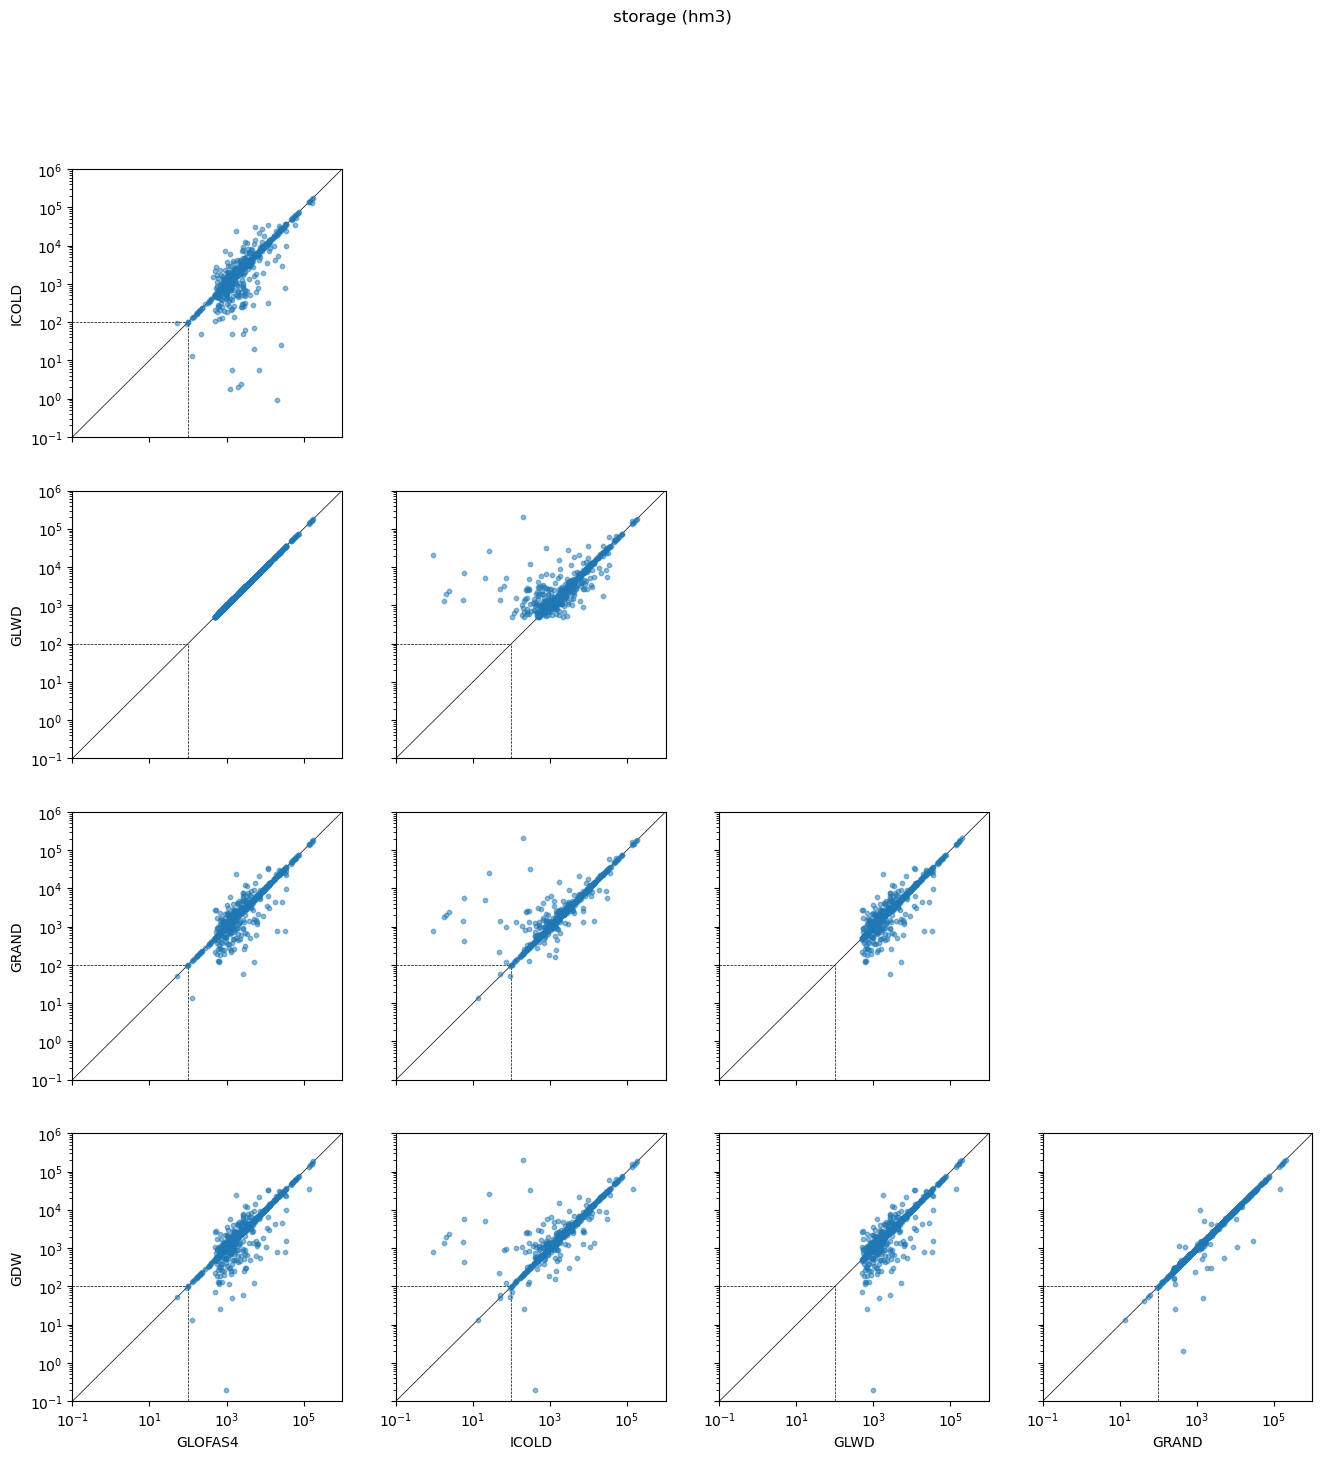

In [19]:
compare_attributes(
    capacity[['GLOFAS4', 'ICOLD', 'GLWD', 'GRAND', 'GDW']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)',
    scale='log',
)
plt.savefig(PATH_OUT / 'plots' / 'storage_pairplot.jpg', dpi=300, bbox_inches='tight')

The values in GLWD and GloFAS4 are identical. However, GRanD values are often different; in some cases, the difference is one order of magnitude. I've checked some of the largest differences and, in all but one case, GRanD was the correct source.

In [20]:
# error = 2
# mask_error = (capacity.GRAND < capacity.GLOFAS4 / error) | (capacity.GRAND > error * capacity.GLOFAS4)
# print(mask_error.sum())
# pd.concat((glofas5.loc[mask_error], capacity[mask_error]), axis=1)

#### Select values

I have manually checked the large discrepancies between GLOFAS4 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from GLOFAS4.

In [21]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GDW', 'ICOLD', 'GLWD']:
    missing = capacity.GLOFAS5.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'GLOFAS5'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

print('{0} reservoirs are missing the capacity value'.format(capacity.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative capacity value'.format((capacity.GLOFAS5 < 0).sum()))
capacity.SOURCE.value_counts()

0 reservoirs are missing the capacity value
0 reservoirs have nevative capacity value


GRAND    1697
GDW        12
ICOLD       1
Name: SOURCE, dtype: int64

8 reservoirs do not comply with the minimum storage of 100 hm3


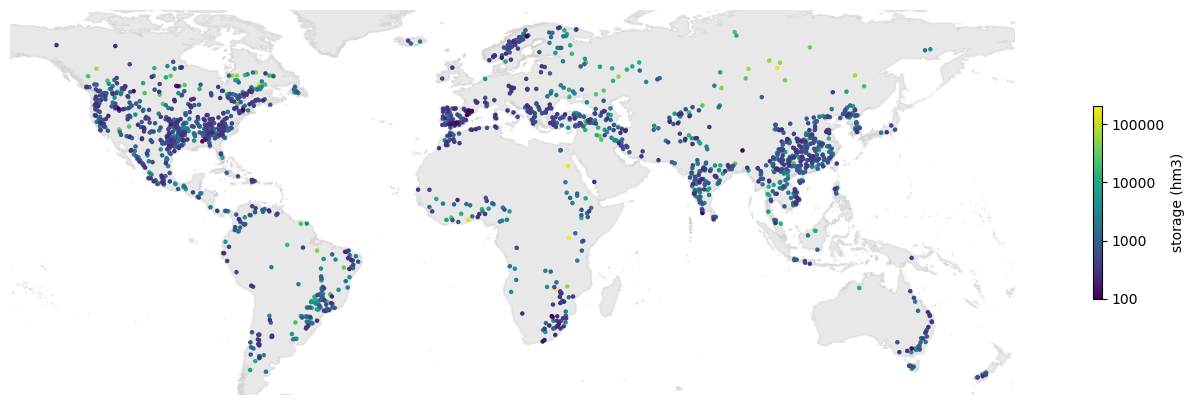

In [22]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(capacity.GLOFAS5),
    cmap='viridis',
    s=5,
    vmin=np.log10(MIN_VOLUME),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='storage (hm3)')
ticks = [2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'storage_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[capacity.index, ['CAP_MCM', 'CAP_SRC']] = capacity[['GLOFAS5', 'SOURCE']].values

print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format((glofas5.CAP_MCM < MIN_VOLUME).sum(),
                                                                                MIN_VOLUME))

### Catchment area

In [23]:
catchment = pd.DataFrame(index=glofas5.index, columns=['UPAREA', 'GDW', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype='float')
catchment.SOURCE = catchment.SOURCE.astype(str)

# upstream area map
catchment.loc[poi_5[idx_name], 'UPAREA'] = np.round(uparea.sel({'x': poi_5['x'], 'y': poi_5['y']}, method='nearest').to_pandas(), 0)

# GDW
catchment.loc[grand.index, 'GDW'] = gdw.CATCH_SKM

# GRanD
catchment.loc[grand.index, 'GRAND'] = grand.CATCH_SKM

# GLWD
catchment.loc[glwd.index, 'GLWD'] = glwd.CATCH_TSKM * 1e3

# ICOLD
catchment.loc[icold.index, 'ICOLD'] = icold.Catch_Area.values

#### Comparison

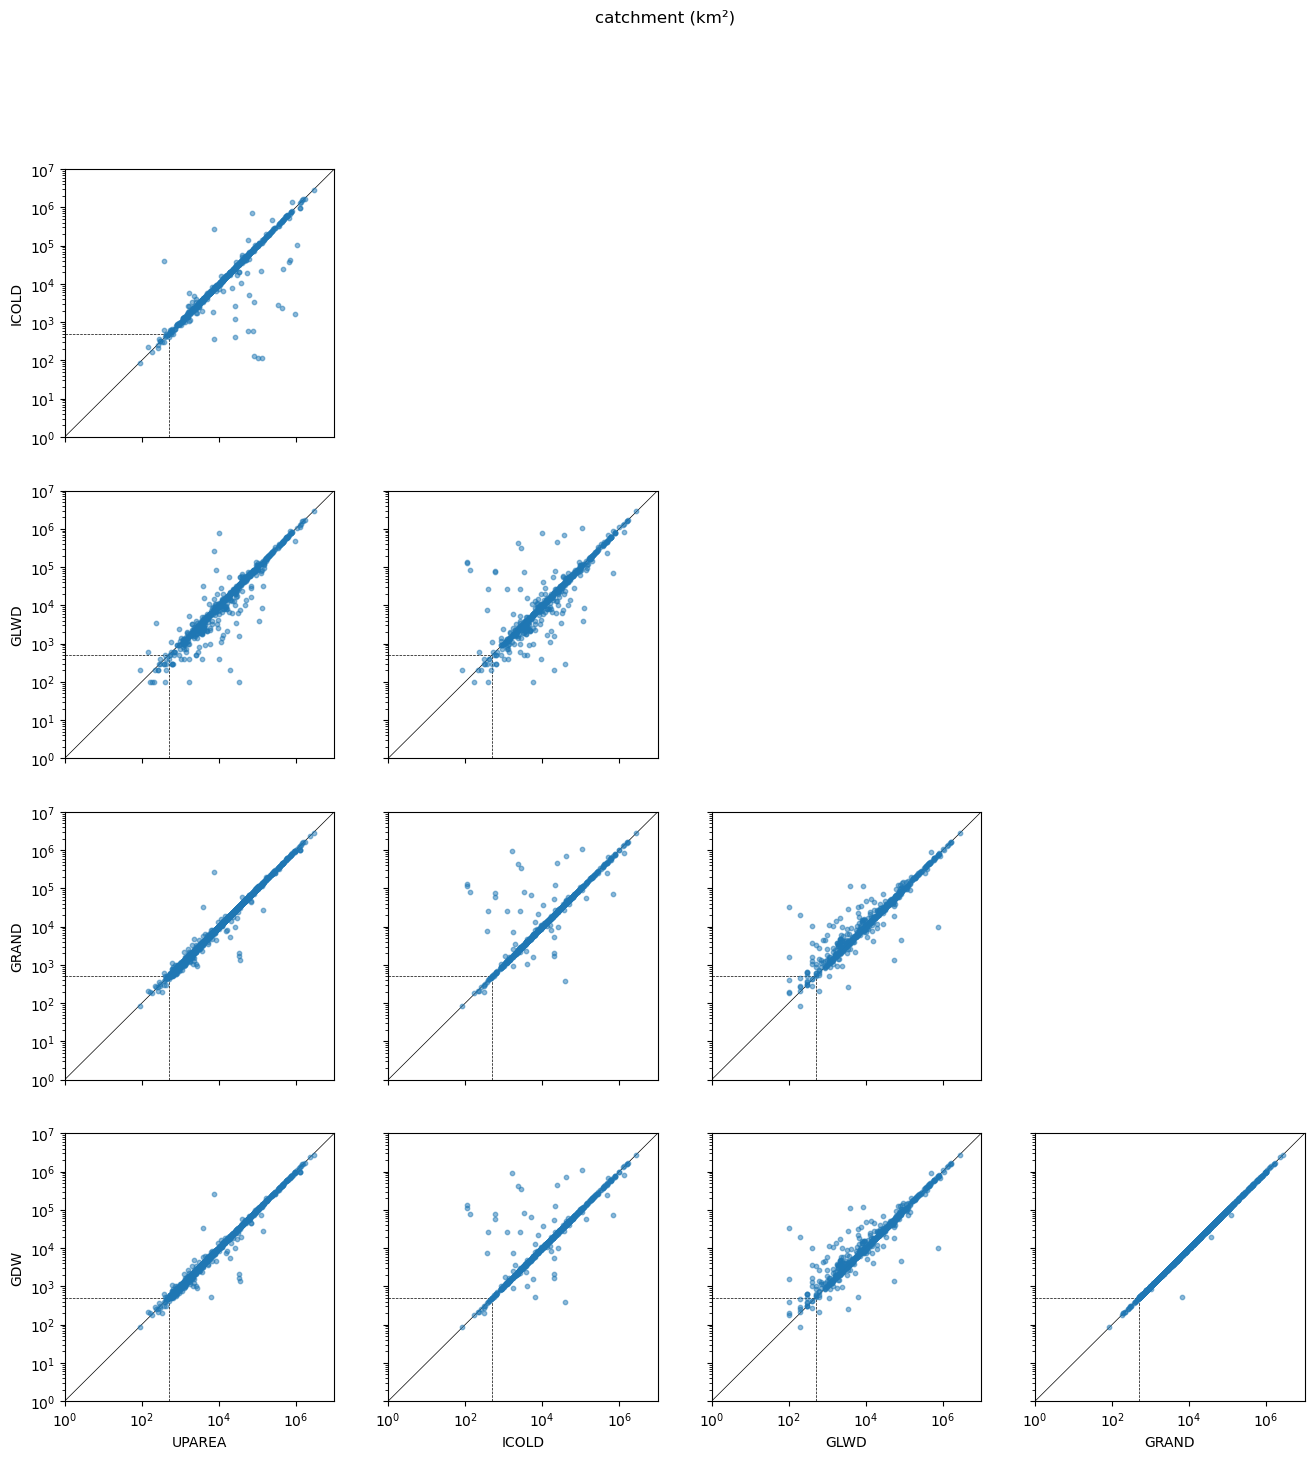

In [24]:
compare_attributes(
    catchment[['UPAREA', 'ICOLD', 'GLWD', 'GRAND', 'GDW']],
    thr=MIN_CATCHMENT,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

In [25]:
# error = 1.5
# mask_error = (catchment.GRAND < catchment.UPAREA / error) | (catchment.GRAND > error * catchment.UPAREA)
# print(mask_error.sum())
# pd.concat((glofas5[mask_error], catchment[mask_error]), axis=1)

In [26]:
# foo = pd.concat(
#     (glofas5[mask_error][['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']],
#      np.round(catchment[mask_error][['UPAREA', 'GRAND', 'GLWD', 'ICOLD']], 0)),
#     axis=1
# ).sort_values('GRAND_ID')

# foo

In [27]:
# foo.to_file(PATH_OUT / 'errors_area.shp')

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

In [28]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GDW', 'GLWD', 'ICOLD', 'UPAREA']:
    missing = catchment.GLOFAS5.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'GLOFAS5'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source

print('{0} reservoirs are missing the catchment value'.format(catchment.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative catchment value'.format((catchment.GLOFAS5 < 0).sum()))
catchment.SOURCE.value_counts()

0 reservoirs are missing the catchment value
0 reservoirs have nevative catchment value


GRAND    1697
GLWD       13
Name: SOURCE, dtype: int64

24 reservoirs do not comply with the minimum catchment area of 500 km²


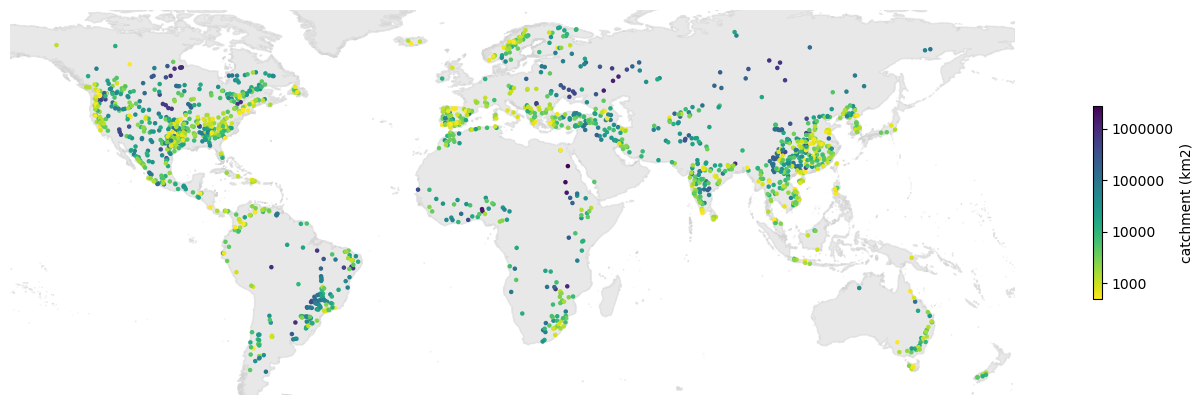

In [29]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(catchment.GLOFAS5),
    cmap='viridis_r',
    s=5,
    vmin=np.log10(MIN_CATCHMENT),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [3, 4, 5, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['GLOFAS5', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((glofas5.CATCH_SKM < MIN_CATCHMENT).sum(),
                                                                                       MIN_CATCHMENT))

### Surface area

In [30]:
area = pd.DataFrame(index=glofas5.index, columns=['GDW', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# GDW
area.loc[gdw.index, 'GDW'] = gdw.AREA_SKM

# GRanD
area.loc[grand.index, 'GRAND'] = grand.AREA_SKM

# GLWD
area.loc[glwd.index, 'GLWD'] = glwd.AREA_SKM

# ICOLD
area.loc[icold.index, 'ICOLD'] = icold.Res_Area.values * 1e-3

#### Comparison

C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1068: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1069: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


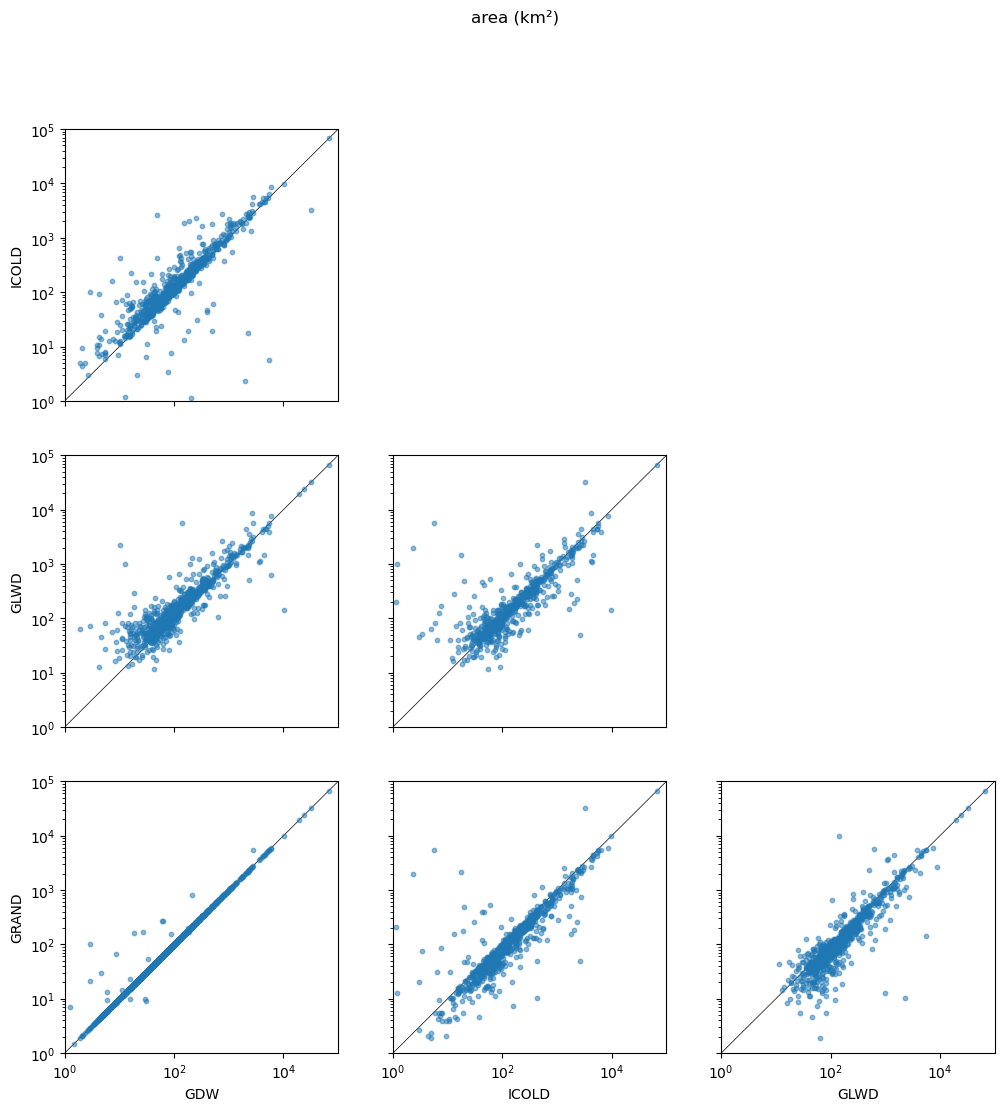

In [31]:
compare_attributes(
    area[['GDW', 'ICOLD', 'GLWD', 'GRAND']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e5,
    title='area (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

There is an error in the units in some ICOLD values.

#### Select values

In [32]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GDW', 'GLWD', 'ICOLD']:
    missing = area.GLOFAS5.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'GLOFAS5'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

print('{0} reservoirs are missing the area value'.format(area.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative area value'.format((area.GLOFAS5 < 0).sum()))
area.SOURCE.value_counts()

1 reservoirs are missing the area value
0 reservoirs have nevative area value


GRAND    1695
GDW        13
nan         1
GLWD        1
Name: SOURCE, dtype: int64

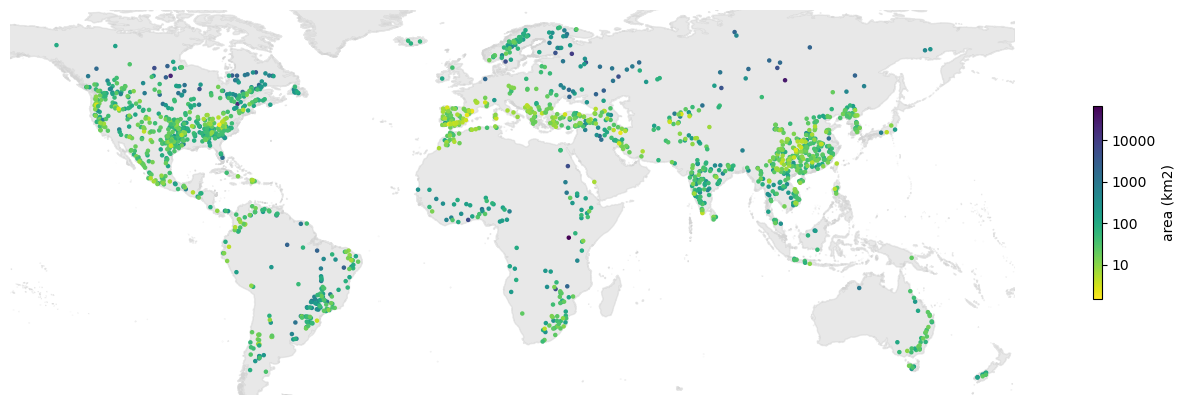

In [33]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(area.GLOFAS5),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [1, 2, 3, 4]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['GLOFAS5', 'SOURCE']].values

### Mean inflow

I do not include the values reported in HydroLakes (`Dis_avg`) because they are identical to those in GRanD.

In [34]:
dis_avg = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GDW', 'GRAND', 'GLWD', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_avg.SOURCE = dis_avg.SOURCE.astype(str)

# GLOFAS4 reservoir parameter
dis_avg.loc[glofas4.index, 'GLOFAS4'] = glofas4.normq

# GLOFAS4 long-run average
# dis_avg['LTR'] = dis_avg_ltr.sel({'x': poi_5['x'], 'y': poi_5['y']}, method='nearest').to_pandas()
dis_avg['LTR'] = extract_timeseries(dis_avg_ltr, poi_4.rename({idx_name: 'id'}), inflow=True, ldd=ldd).to_pandas()
# dis_avg['LTR'] = inflow_ltr.mean('time')

# GDW
dis_avg.loc[mask.index, 'GDW'] = gdw.DIS_AVG_LS * 1e-3

# GRanD
dis_avg.loc[mask.index, 'GRAND'] = grand.DIS_AVG_LS * 1e-3

# GLWD
dis_avg.loc[glwd.index, 'GLWD'] = glwd.INFLOW_CMS

#### Comparison

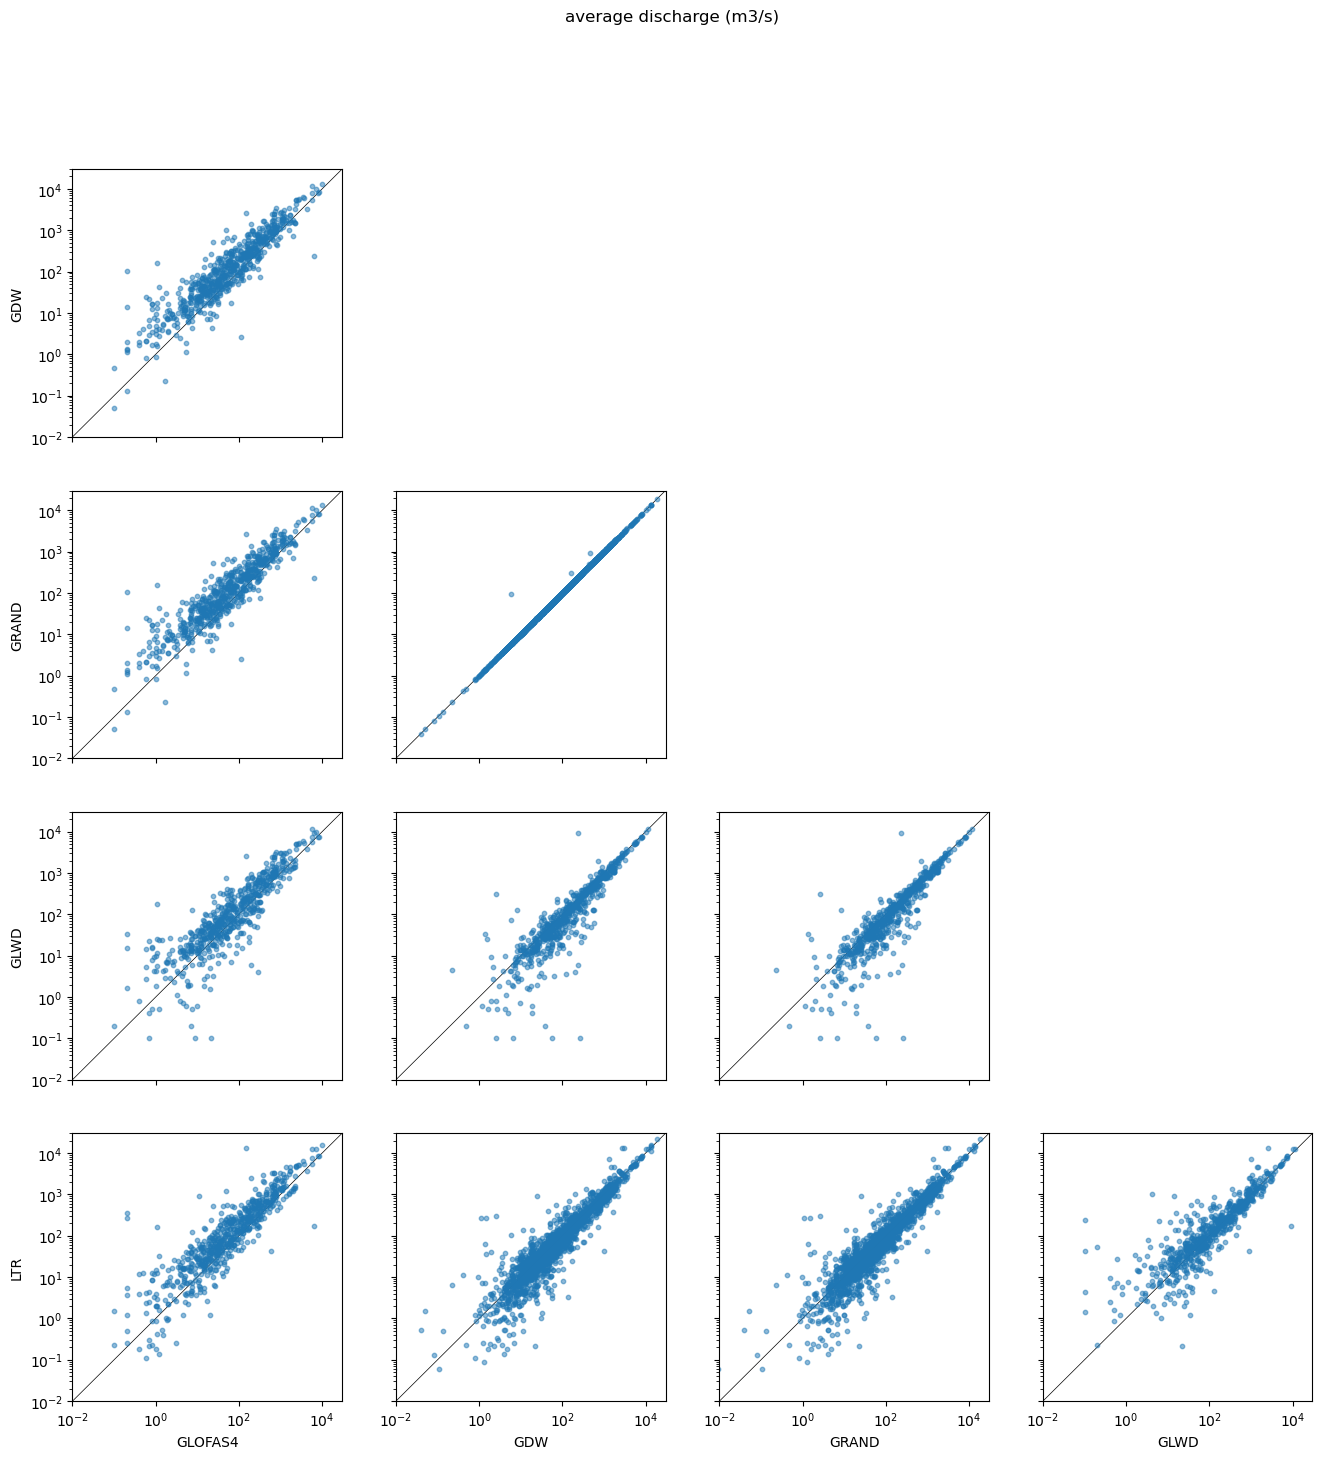

In [35]:
compare_attributes(
    dis_avg[['GLOFAS4', 'GDW', 'GRAND', 'GLWD', 'LTR']],
    thr=0,
    vmin=0.01,
    vmax=3e4,
    title='average discharge (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values
I will use in all cases the average flow in the long-term run.

37 reservoirs have an average inflow below 1 m3/s


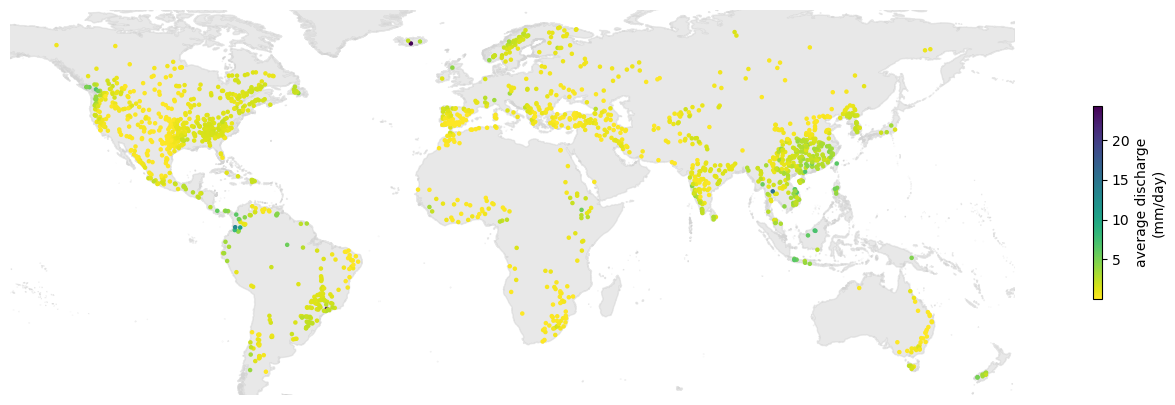

In [36]:
# select values from the GLOFAS4 long-term run
dis_avg.GLOFAS5 = dis_avg.LTR
dis_avg.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_avg.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_avg.index, 'DISAVG_CMS'] = dis_avg['GLOFAS5'].round(1).values

print('{0} reservoirs have an average inflow below 1 m3/s'.format((glofas5.DISAVG_CMS < 1).sum()))

### Degree of regulation

The degree of regulation is the amount of annual inflow that the reservoir can store. I'll cap this value to 100 years (same as GRanD does), since it's not feasible that a reservoir was designed to store that amount of water.

In [37]:
dor = pd.DataFrame(index=glofas5.index, columns=['GLOFAS5', 'GDW', 'GRAND', 'GLWD'], dtype=float)

# GLOFAS5
dor['GLOFAS5'] = np.minimum(glofas5.CAP_MCM * 1e6 / (glofas5.DISAVG_CMS  * 24 * 3600 * 365), 100)

# GWD
dor.loc[gdw.index, 'GDW'] = gdw.DOR_PC.values / 100

# GRanD
dor.loc[grand.index, 'GRAND'] = grand.DOR_PC.values / 100

# GLWD
dor.loc[glwd.index, 'GLWD'] = np.minimum(glwd.VOLUME_CKM * 1e9 / (glwd.INFLOW_CMS * 24 * 3600 * 365), 100)

#### Comparison

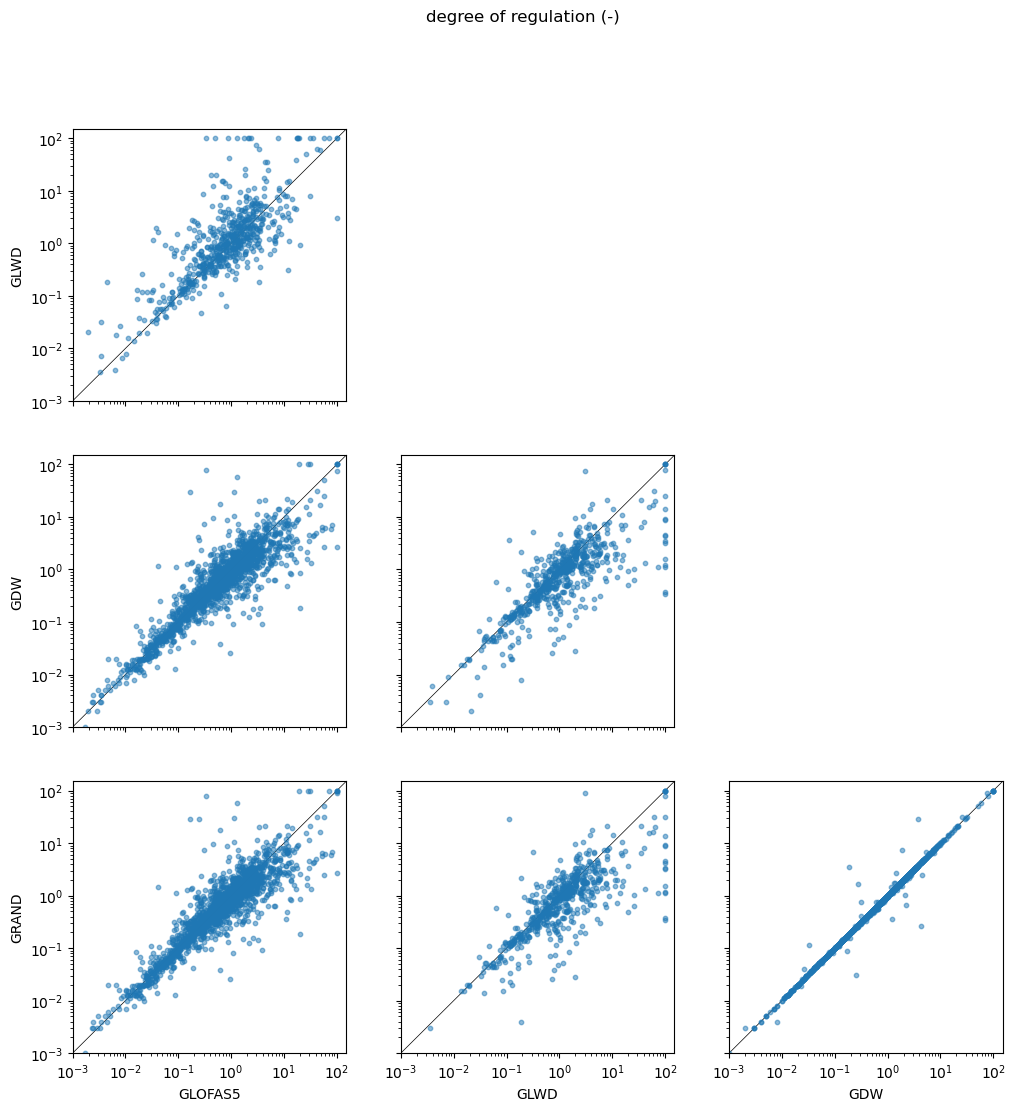

In [38]:
compare_attributes(
    dor[['GLOFAS5', 'GLWD', 'GDW', 'GRAND']],
    thr=0,
    vmin=0.001,
    vmax=150,
    title='degree of regulation (-)'
)
plt.savefig(PATH_OUT / 'plots' / 'dor_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

I will use the values obtained from the attributes in GLOFAS5.

220 reservoirs do not comply with the minimum degree of regulation 0.08
77 reservoirs have a degree of regulation larger than 10 years


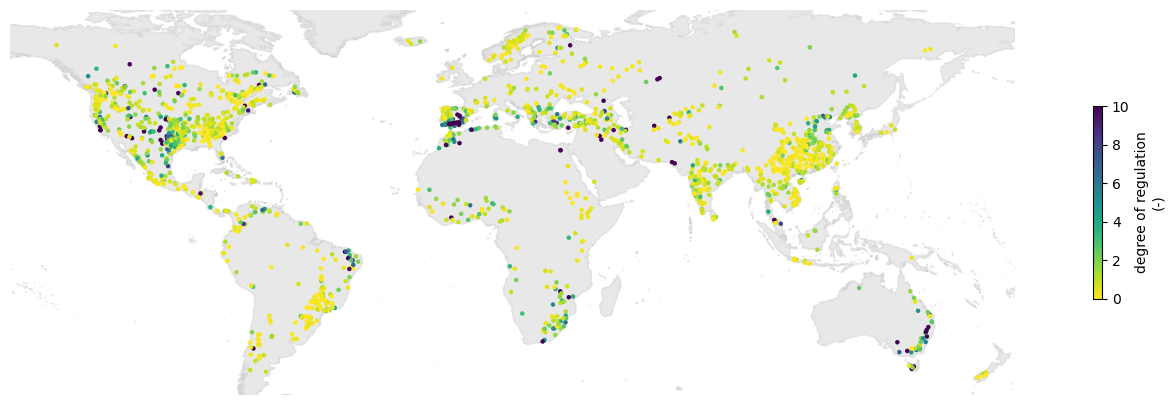

In [39]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dor.GLOFAS5,
    cmap='viridis_r',
    s=5,
    vmin=0,
    vmax=10
)
cbar = plt.colorbar(sct, shrink=.5, label='degree of regulation\n(-)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dor_map.jpg', dpi=300, bbox_inches='tight')

glofas5['DOR'] = dor.GLOFAS5.round(3)

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format((glofas5.DOR < MIN_DOR).sum(),
                                                                                       MIN_DOR))
print('{0} reservoirs have a degree of regulation larger than 10 years'.format((glofas5.DOR > 10).sum()))

There are problems in the computation of the degree of regulation, inherited either from the reservoir storage or the average inflow. It's not realistic that 84 reservoirs were designed to store 10 years of inflow.

### 100-year return period

In [40]:
dis_100 = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_100.SOURCE = dis_100.SOURCE.astype(str)

# GLOFAS4
dis_100.loc[glofas4.index, 'GLOFAS4'] = glofas4.ndq

# GLOFAS4 long-run average
# dis_100['LTR'] = dis_100_ltr.sel({'x': poi_5['x'], 'y': poi_5['y']}, method='nearest').to_pandas()
dis_100['LTR'] = extract_timeseries(dis_100_ltr, poi_4.rename({idx_name: 'id'}), inflow=True, ldd=ldd).to_pandas()
# dis_100['LTR'] = pd.Series({ID: return_period(inflow_ltr.sel(ID=ID).to_pandas(), T=100) for ID in inflow_ltr.ID.data})

#### Comparison

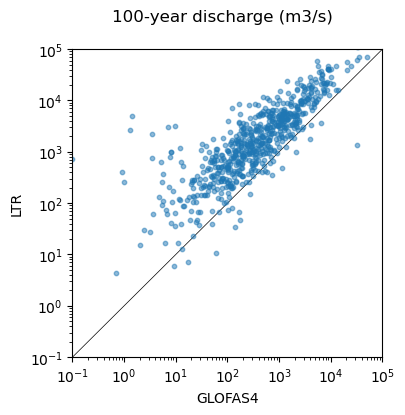

In [41]:
compare_attributes(
    dis_100[['GLOFAS4', 'LTR']],
    thr=0,
    vmin=0.1,
    vmax=1e5,
    title='100-year discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_100_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

7 reservoirs have an 100-year inflow below 10 m3/s


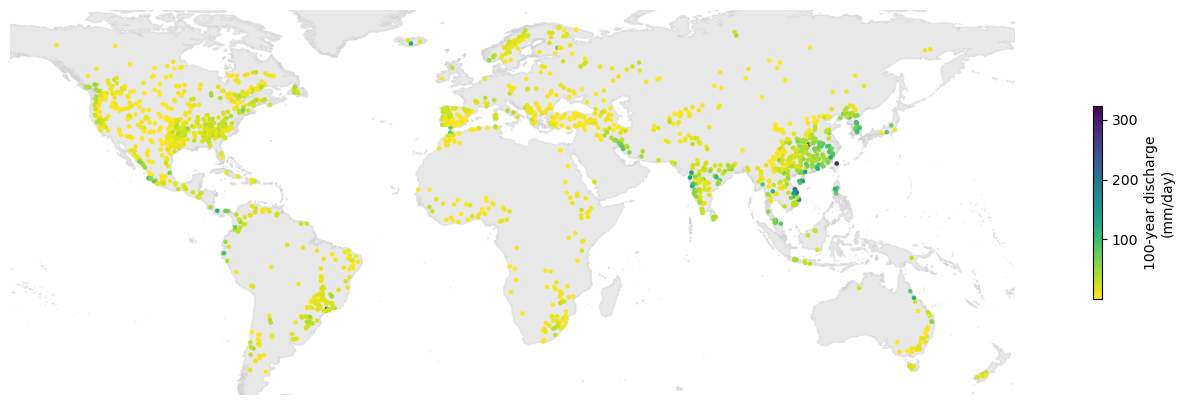

In [42]:
# select values from the GLOFAS4 long-term run
dis_100.GLOFAS5 = dis_100.LTR
dis_100.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_100.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='100-year discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_100_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_100.index, 'DIS100_CMS'] = dis_100['GLOFAS5'].round(1).values

print('{0} reservoirs have an 100-year inflow below 10 m3/s'.format((glofas5.DIS100_CMS < 10).sum()))

### Environment flow

In [43]:
dis_env = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_env.SOURCE = dis_env.SOURCE.astype(str)

# GLOFAS4
dis_env.loc[glofas4.index, 'GLOFAS4'] = glofas4.minq

# GLOFAS4 long-term run
# dis_env['LTR'] = inflow_ltr.quantile(.05, dim='time', skipna=True).to_pandas()
dis_env['LTR'] = .05 * dis_avg.GLOFAS5 # simplification of the French regulation

#### Comparison

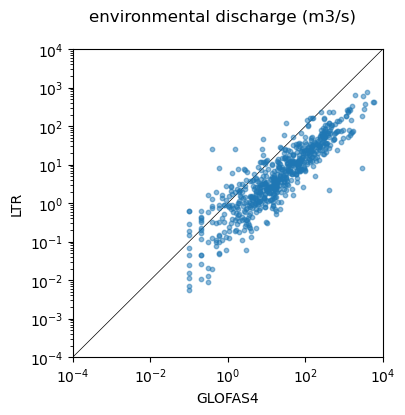

In [44]:
compare_attributes(
    dis_env[['GLOFAS4', 'LTR']],
    thr=0,
    vmin=1e-4,
    vmax=1e4,
    title='environmental discharge (m3/s)',
    scale='log'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_env_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

I will select the values extracted from the D2 map, as it limits extremely low values.

65 reservoirs have an environmental flow below 0.1 m3/s


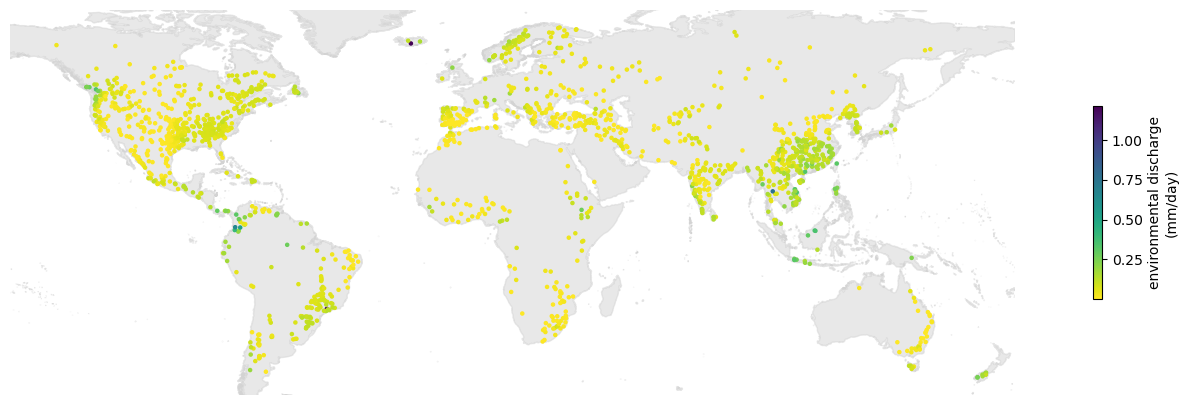

In [45]:
# select values from the GLOFAS4 naturalised run
dis_env.GLOFAS5 = dis_env.LTR
dis_env.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_env.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='environmental discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_env_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_env.index, 'DISENV_CMS'] = dis_env['GLOFAS5'].round(4).values

print('{0} reservoirs have an environmental flow below 0.1 m3/s'.format((glofas5.DISENV_CMS < 0.1).sum()))

There are very low values of environmental flow.

## Export
### Excel file

In [46]:
# copy glofas5 as main source
reservoirs = glofas5.copy()
reservoirs.sort_index(inplace=True)

# LISFLOOD coordinates
reservoirs['LisfloodX'] = reservoirs.geometry.x
reservoirs['LisfloodY'] = reservoirs.geometry.y

# source of discharge data
reservoirs['DIS_SRC'] = 'GLOFAS4_ltr'

# # add data from GRanD
# grand_ids = reservoirs.GRAND_ID.dropna()
# grand_cols = ['RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR', 'REM_YEAR', 'LONG_DD', 'LAT_DD']
# reservoirs.loc[grand_ids.index, grand_cols] = grand.loc[grand_ids.index, grand_cols].values

# add data from GDW
gdw_cols = ['RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR_DAM', 'REM_YEAR', 'LONG_RIV', 'LAT_RIV']
gdw_ids = gdw.index.intersection(reservoirs.index)
reservoirs.loc[gdw_ids, gdw_cols] = gdw.loc[gdw_ids, gdw_cols]

# add info from GLOFAS4
ids = reservoirs[reservoirs.GRAND_ID.isnull() & reservoirs.RES_ID.notnull()].index
cols_glofas4 = ['COUNTRY', 'DAM_NAME', 'RIVER']
reservoirs.loc[ids, cols_glofas4] = glofas4.loc[ids, cols_glofas4]

# reorder and rename columns
cols = ['RES_ID', 'GDW_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE'] + \
    gdw_cols +  \
    ['LisfloodX', 'LisfloodY',
     'CAP_MCM', 'CAP_SRC', 'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC',
     'DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS', 'DIS_SRC', 'DOR',
     'geometry']
cols.remove(idx_name)
reservoirs = reservoirs[cols]

# reservoirs that will be modelled as reservoirs
mask_res = (reservoirs.DOR >= MIN_DOR) | reservoirs.AREA_SKM.isnull()
print('{0} reservoirs will be modelled as lakes'.format((~mask_res).sum()))

xls_file = PATH_OUT / 'glofas5_reservoirs_{0}.xlsx'.format(datetime.now().strftime('%Y%m%d'))
with pd.ExcelWriter(xls_file, engine='openpyxl') as writer:
    # Reservoirs in GLOFAS5 (as reservoirs)
    reservoirs[mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_reservoirs', float_format='%.4f')
    
    # Reservoirs modeled as lakes in GLOFAS5 (as lakes)
    reservoirs[~mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_lakes', float_format='%.4f')
print(f'Reservoir Excel table saved in : {xls_file}')

220 reservoirs will be modelled as lakes
Reservoir Excel table saved in : Z:\nahaUsers\casadje\GloFASv5\reservoirs\tables\glofas5_reservoirs_20250228.xlsx


### TXT tables

In [47]:
# filter reservoirs to be modelled as reservoirs
# res = pd.read_excel(PATH_OUT / 'glofas5_reservoirs.xlsx', sheet_name='as_reservoirs', index_col='FID')
# res.sort_index(inplace=True)
res = reservoirs[mask_res].sort_index()

# table reservoir capacity
(res.CAP_MCM * 1e6).to_csv(
    PATH_OUT / 'reservoirs_glofas5_capacity_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None,
    float_format='%.0f'
)

# table average discharge
res.DISAVG_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_glofas5_avg_inflow_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

# table 100-year discharge
res.DIS100_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_glofas5_100yr_inflow_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

# table environmental flow
res.DISENV_CMS.round(3).to_csv(
    PATH_OUT / 'reservoirs_glofas5_env_flow_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

# years of construction and demolition
res[['YEAR_DAM', 'REM_YEAR']].rename(columns={'YEAR_DAM': 'CONSTR_YEAR', 'REM_YEAR': 'DEMOL_YEAR'}).to_csv(
    PATH_OUT / 'reservoirs_glofas5_years_ {0}.csv'.format(datetime.now().strftime('%Y%m%d')),
)

### NetCDF map

In [51]:
# load map from GloFAS4
mapa = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / '20220802_reservoirs_Global_03min.nc')#.squeeze(dim='band').astype(int)
mapa.close()

# remove all lakes
mapa[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(res.iterrows(), total=len(res)):
    pixel = mapa.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    mapa.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = ID

# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.globaldamwatch.org/grand'
mapa.attrs['long_name'] = 'reservoirs'

# define coordinate reference system
mapa = mapa.rio.write_crs('EPSG:4326')

# export NetCDF map
mapa.rio.to_raster(PATH_OUT / 'reservoirs_glofas5_03min_{0}.nc'.format(datetime.now().strftime('%Y%m%d')))

  0%|          | 0/1490 [00:00<?, ?it/s]